In [1]:
# COMP 5300 Final Project
# Musculoskeletal Abnormality Detection
# Michelle, Jennifer, Amelia, Deva

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
%matplotlib inline
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2024-04-19 21:30:46.417141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 21:30:46.936723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/amelia/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def restructure_dataset(path):
    data = []
    
    for study_type in os.listdir(path):
        # Get study type path to access patient folders
        study_type_path = path + '/' + str(study_type)

        for patient_id in os.listdir(study_type_path):
            # Get patient id path to access study folders
            study_id = study_type_path + '/' + str(patient_id)
            for label in os.listdir(study_id):
                # Get abnormality label as positive (1) or negative (0)
                if label.split('_')[-1] == 'positive': 
                    num_label = 1
                elif label.split('_')[-1] == 'negative':
                    num_label = 0

                # Get study id and label path to access image folders
                label_path = study_id + '/' + str(label)
                for img in os.listdir(label_path):
                    img_path = label_path + '/' + str(img)

                    # Add data to array
                    data.append(
                        {
                            'study_type': study_type,
                            'patient_id': patient_id,
                            'img_path': img_path,
                            'label': num_label,
                        }
                    )
    return data

In [4]:
# Consolidate all training data into single dataframe 
df_train = pd.DataFrame(restructure_dataset('MURA-v1.1/train'))
df_train.head()

,study_type,patient_id,img_path,label
0,XR_FOREARM,patient09232,MURA-v1.1/train/XR_FOREARM/patient09232/study1...,1
1,XR_FOREARM,patient09232,MURA-v1.1/train/XR_FOREARM/patient09232/study1...,1
2,XR_FOREARM,patient09202,MURA-v1.1/train/XR_FOREARM/patient09202/study1...,1
3,XR_FOREARM,patient09202,MURA-v1.1/train/XR_FOREARM/patient09202/study1...,1
4,XR_FOREARM,patient09396,MURA-v1.1/train/XR_FOREARM/patient09396/study1...,0


In [5]:
df_train.shape

(36812, 4)

In [6]:
df_train.isnull().sum()

study_type    0
patient_id    0
img_path      0
label         0
dtype: int64

In [7]:
# Preprocessing & stratified sampling to get validation dataset

df_train['combined_study_type_label'] = df_train['study_type'] + '_' + df_train['label'].astype(str)

df_train, df_valid = train_test_split(df_train, test_size = 0.1, stratify = df_train['combined_study_type_label'])

df_train = df_train.drop(columns=['combined_study_type_label'])
df_valid = df_valid.drop(columns=['combined_study_type_label'])

In [8]:
df_train.head()

,study_type,patient_id,img_path,label
15223,XR_SHOULDER,patient01172,MURA-v1.1/train/XR_SHOULDER/patient01172/study...,1
665,XR_FOREARM,patient09653,MURA-v1.1/train/XR_FOREARM/patient09653/study1...,0
12913,XR_SHOULDER,patient00987,MURA-v1.1/train/XR_SHOULDER/patient00987/study...,1
29544,XR_WRIST,patient06731,MURA-v1.1/train/XR_WRIST/patient06731/study1_p...,1
14358,XR_SHOULDER,patient01634,MURA-v1.1/train/XR_SHOULDER/patient01634/study...,0


In [9]:
df_train.shape

(33130, 4)

In [10]:
df_valid.head()

,study_type,patient_id,img_path,label
18294,XR_SHOULDER,patient01836,MURA-v1.1/train/XR_SHOULDER/patient01836/study...,0
32691,XR_ELBOW,patient05388,MURA-v1.1/train/XR_ELBOW/patient05388/study1_p...,1
3898,XR_HAND,patient10045,MURA-v1.1/train/XR_HAND/patient10045/study1_po...,1
6500,XR_HAND,patient02324,MURA-v1.1/train/XR_HAND/patient02324/study1_ne...,0
4377,XR_HAND,patient10855,MURA-v1.1/train/XR_HAND/patient10855/study1_ne...,0


In [11]:
df_valid.shape

(3682, 4)

In [12]:
# Consolidate all test data into single dataframe
df_test = pd.DataFrame(restructure_dataset('MURA-v1.1/valid'))
df_test.head()

,study_type,patient_id,img_path,label
0,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0
1,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0
2,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0
3,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0
4,XR_FOREARM,patient11408,MURA-v1.1/valid/XR_FOREARM/patient11408/study1...,1


In [13]:
df_test.shape

(3197, 4)

In [14]:
df_test.isnull().sum()

study_type    0
patient_id    0
img_path      0
label         0
dtype: int64

In [15]:
# Find problematic images and remove them from the dataset (amelia)
# https://stackoverflow.com/questions/71572762/cannot-identify-image-file-io-bytesio-object-at-0x000001e6cf13a108
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

all_image_paths = []
all_image_paths.extend(df_train['img_path'])
all_image_paths.extend(df_valid['img_path'])
all_image_paths.extend(df_test['img_path'])

problem_paths = []

for img_p in all_image_paths:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        print(img_p)
        problem_paths.append(img_p)

for prob_path in problem_paths:
    df_train.drop(df_train.loc[df_train['img_path']==prob_path].index, inplace=True)
    df_valid.drop(df_valid.loc[df_valid['img_path']==prob_path].index, inplace=True)
    df_test.drop(df_test.loc[df_test['img_path']==prob_path].index, inplace=True)

MURA-v1.1/train/XR_WRIST/patient07840/study1_negative/._image1.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image1.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image3.png
MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image2.png


In [16]:
# Convert labels to str
df_train['label'] = df_train['label'].replace({0: '0', 1: '1'})
df_valid['label'] = df_valid['label'].replace({0: '0', 1: '1'})
df_test['label'] = df_test['label'].replace({0: '0', 1: '1'})

In [17]:
# Data augmentation
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 33126 validated image filenames belonging to 2 classes.


In [18]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 3682 validated image filenames belonging to 2 classes.


In [19]:
test_generator = datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = None,
    x_col = 'img_path',
    y_col = 'label',
    batch_size = 64,
    shuffle = False,
    class_mode = 'binary',
    target_size = (224, 224),
)

Found 3197 validated image filenames belonging to 2 classes.


In [20]:
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
# https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
# https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


print("Current CUDA device:", tf.test.gpu_device_name())

Current CUDA device: /device:GPU:0


2024-04-19 21:30:49.139163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.164877: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.165079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [21]:
#this is the VGG model with weights already pretrained from imagenet 
#had to decrease size of images due to computational resources 
#did not include the fully connected layers because this is a different task compared to imagenet tasks

img_width = 224  # keep image sizes consistent with Michelle's code
img_height = 224

vmodel = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
vmodel.trainable = False

print(vmodel.summary())
print("Current CUDA device:", tf.test.gpu_device_name())

2024-04-19 21:30:49.250370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.250564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.250708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Current CUDA device: /device:GPU:0


2024-04-19 21:30:49.537364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.537554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.537694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [22]:
#adding the last layers for our specifc tasks
#https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
#the number of layers and neurons are arbtituary we can add or remove amount

#numbers 58, 28, 7, 1 represent the number of neurons
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from tensorflow.keras import metrics

#TODO: Explore ways to adjust these parameters so it can converge 
#less or more layers, edit numbers of neurons.
#more neurons means problems is very complex 

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(58, activation='relu')
dense_layer_2 = layers.Dense(28, activation='relu')
dense_layer_3 = layers.Dense(7, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid') #binary classification

model = models.Sequential([
    vmodel,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.summary()


#optimzer was very easy to include
#article includes early stopping to generalize data more and prevent overfitting maybe this is something we can do as a stretch goal
cut_off = 0.5
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001*3),
    loss = losses.BinaryCrossentropy(from_logits=False),
    metrics=[metrics.BinaryAccuracy(threshold=cut_off),
            metrics.Precision(thresholds=cut_off),
            metrics.Recall(thresholds=cut_off),
            metrics.AUC(),
            ],
)

#dispaly model summary of our new model
model.summary()
print("Current CUDA device:", tf.test.gpu_device_name())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Current CUDA device: /device:GPU:0


2024-04-19 21:30:49.577134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.577336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:30:49.577481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [23]:
import math
epochs = 100

def SquareRootScheduler(epochCount, lr):
    return lr * pow(epochCount+1.0, -0.5)

tmpEpochs = list(range(50))
tmpLr = list(map(lambda x: SquareRootScheduler(x, tf.keras.optimizers.Adam().get_config()["learning_rate"]*3), tmpEpochs))

cb_lrscheduler = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler)
cb_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=math.floor(epochs*0.1))

In [24]:
#TRAIN MODEL HERE

import time
start_time = time.time()
training_results = model.fit(
    train_generator,
    batch_size = None,
    validation_data = valid_generator,
    validation_batch_size = None,
    epochs = epochs,
    callbacks = [cb_lrscheduler, cb_earlystopping],
    verbose=1,
)
print(f'Trained model in {time.time()-start_time}s')

model.save('vggmodel.keras')

Epoch 1/100


/home/amelia/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713576652.079081   10987 service.cc:145] XLA service 0x7efd8400f680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713576652.079113   10987 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-04-19 21:30:52.127754: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-19 21:30:52.320835: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-1

  1/518 ━━━━━━━━━━━━━━━━━━━━ 1:51:26 13s/step - auc: 0.5152 - binary_accuracy: 0.4844 - loss: 0.6995 - precision: 0.4828 - recall: 0.9032

I0000 00:00:1713576662.734938   10987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/518 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - auc: 0.6112 - binary_accuracy: 0.6025 - loss: 0.8120 - precision: 0.5144 - recall: 0.4217

2024-04-19 21:32:01.367714: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-19 21:32:01.937328: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.6260 - binary_accuracy: 0.6134 - loss: 0.7736 - precision: 0.5310 - recall: 0.4274

2024-04-19 21:32:36.274728: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-19 21:32:36.787342: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


518/518 ━━━━━━━━━━━━━━━━━━━━ 112s 192ms/step - auc: 0.6261 - binary_accuracy: 0.6135 - loss: 0.7734 - precision: 0.5311 - recall: 0.4274 - val_auc: 0.7703 - val_binary_accuracy: 0.6757 - val_loss: 0.5821 - val_precision: 0.5764 - val_recall: 0.7453 - learning_rate: 0.0030
Epoch 2/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 86s 165ms/step - auc: 0.7664 - binary_accuracy: 0.7127 - loss: 0.5570 - precision: 0.6817 - recall: 0.5418 - val_auc: 0.7898 - val_binary_accuracy: 0.7143 - val_loss: 0.5611 - val_precision: 0.8574 - val_recall: 0.3515 - learning_rate: 0.0021
Epoch 3/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 87s 165ms/step - auc: 0.8038 - binary_accuracy: 0.7417 - loss: 0.5186 - precision: 0.7257 - recall: 0.5753 - val_auc: 0.7874 - val_binary_accuracy: 0.7230 - val_loss: 0.5489 - val_precision: 0.8039 - val_recall: 0.4160 - learning_rate: 0.0012
Epoch 4/100
518/518 ━━━━━━━━━━━━━━━━━━━━ 87s 166ms/step - auc: 0.8348 - binary_accuracy: 0.7671 - loss: 0.4849 - precision: 0.7621 - recall: 0.6153 - val_auc: 

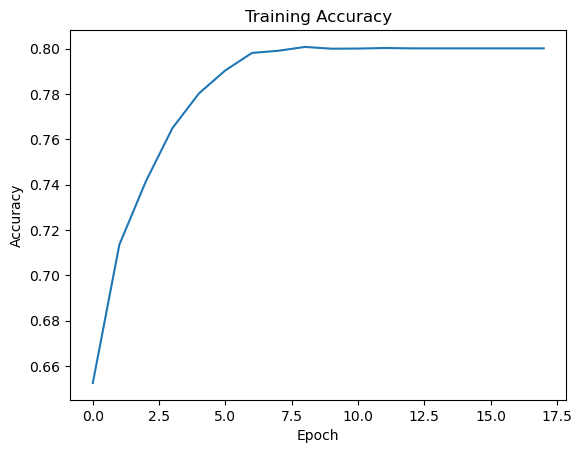

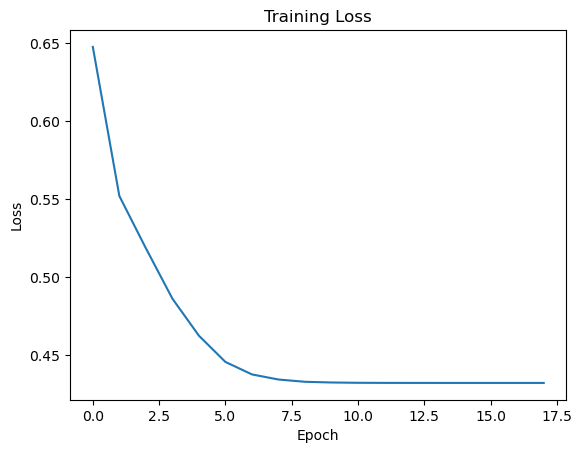

In [25]:
#visualization and scores
# training accuracy
plt.plot(training_results.history['binary_accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# training loss
plt.plot(training_results.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

[0.7330255508422852,
 0.6411098885305565,
 0.8036110401153564,
 0.5201128125190735,
 18]

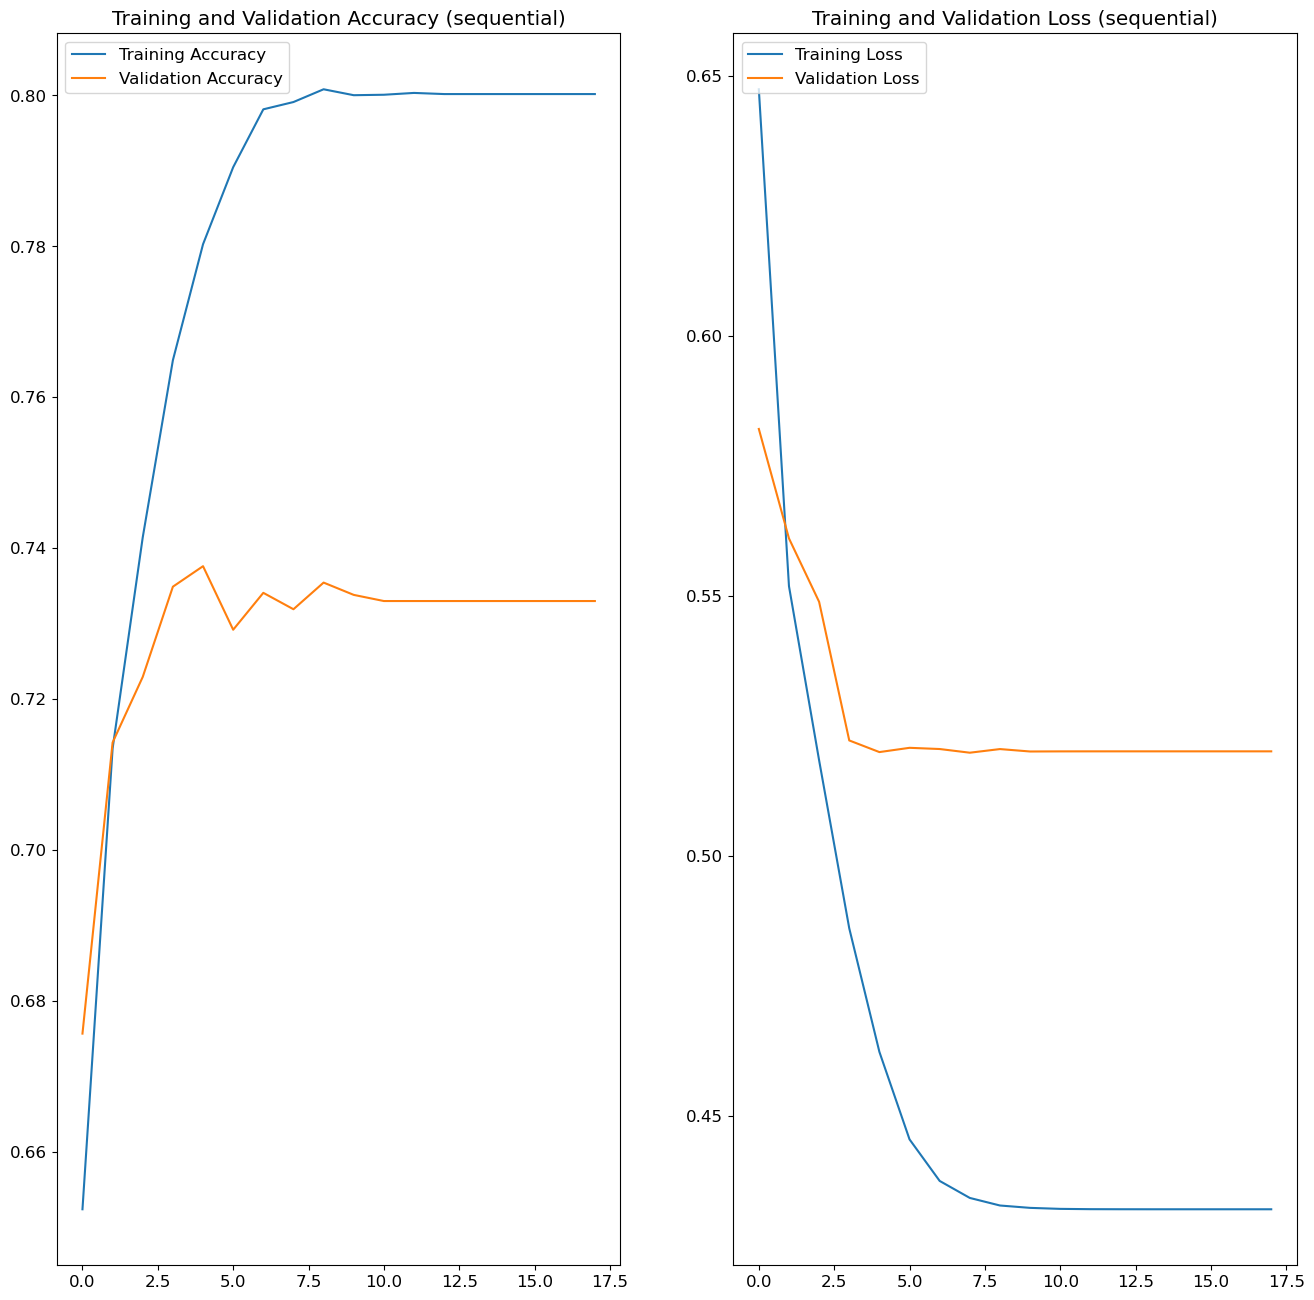

In [26]:
def PlottingResult(his, result, name):
    acc = his.history['binary_accuracy']
    val_acc = his.history['val_binary_accuracy']
    loss = his.history['loss']
    val_loss = his.history['val_loss']

    plt.figure(figsize=(16, 16))
    plt.rc('font', size=12)

    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='upper left')
    title = 'Training and Validation Accuracy (' + his.model.name + ')'
    plt.title(title)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper left')
    title = 'Training and Validation Loss (' + his.model.name + ')'
    plt.title(title)

    bestIdx = 0
    val_accuracy = 0
    val_precision = 0
    val_recall = 0
    val_auc = 0
    val_f1 = 0

    for i,j in his.history.items():
        if "val_loss" in i:
            bestIdx = np.argmin(j)
            val_loss = j[-1]

    for i,j in his.history.items():
        if "val_binary_accuracy" in i:
            val_accuracy = j[-1]
        elif "val_precision" in i:
            val_precision = j[-1]
        elif "val_recall" in i:
            val_recall = j[-1]
        elif "val_auc" in i:
            val_auc = j[-1]
            
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

    return [val_accuracy, val_f1, val_auc, val_loss, len(his.epoch)]

result = pd.DataFrame({'Accuracy' : [None],
        'F1' : [None],
        'AUC' : [None],
        'Loss' : [None],
        'Epoch' : [None]                
})
result.index = ['VGGNet']

result = PlottingResult(training_results, result, 'DenseNet201')
result

In [27]:
test_generator.reset()
df_test['pred'] = model.predict(test_generator).ravel()
df_test

/home/amelia/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

2024-04-19 21:57:31.323862: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-19 21:57:31.882407: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-19 21:57:32.792229: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-19 21:57:35.224428: W external/local_tsl/tsl/framework/bfc_

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 340ms/step


,study_type,patient_id,img_path,label,pred
0,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0.365177
1,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0.353483
2,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,0.398641
3,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,0.510970
4,XR_FOREARM,patient11408,MURA-v1.1/valid/XR_FOREARM/patient11408/study1...,1,0.089523
...,...,...,...,...,...
3192,XR_ELBOW,patient11536,MURA-v1.1/valid/XR_ELBOW/patient11536/study1_n...,0,0.020032
3193,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0.044017
3194,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0.059250
3195,XR_ELBOW,patient11875,MURA-v1.1/valid/XR_ELBOW/patient11875/study1_n...,0,0.584232


In [28]:
df_test['pred'] = np.where(df_test.pred>0.5, 1, 0)
df_test

,study_type,patient_id,img_path,label,pred
0,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0
1,XR_FOREARM,patient11463,MURA-v1.1/valid/XR_FOREARM/patient11463/study1...,0,0
2,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,0
3,XR_FOREARM,patient11449,MURA-v1.1/valid/XR_FOREARM/patient11449/study1...,0,1
4,XR_FOREARM,patient11408,MURA-v1.1/valid/XR_FOREARM/patient11408/study1...,1,0
...,...,...,...,...,...
3192,XR_ELBOW,patient11536,MURA-v1.1/valid/XR_ELBOW/patient11536/study1_n...,0,0
3193,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0
3194,XR_ELBOW,patient11402,MURA-v1.1/valid/XR_ELBOW/patient11402/study1_n...,0,0
3195,XR_ELBOW,patient11875,MURA-v1.1/valid/XR_ELBOW/patient11875/study1_n...,0,1


In [29]:
df_test.to_csv('test_w_preds_vgg.csv')